## **FOR COLAB**

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


## **General Import**

In [3]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else :
  print(gpu_info)

Wed Dec  8 12:30:37 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
from psutil import virtual_memory
ram_gb = virtual_memory().total/1e9
print('Your runtime has {:.1f} gigabyte of available RAM\n'.format(ram_gb))

if ram_gb < 20 :
  print('Not using a high-RAM runtime')
else :
  print('You are using a high-RAM runtime !')

Your runtime has 27.3 gigabyte of available RAM

You are using a high-RAM runtime !


In [5]:
!pip install catboost

In [12]:
import numpy as np 
import pandas as pd 
import networkx as nx
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import ast

In [13]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_regression
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from gensim.models import Word2Vec, KeyedVectors
from tensorflow import keras

In [14]:
from catboost import CatBoostRegressor, Pool
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression, LassoCV
from sklearn.manifold import TSNE

## **Data Retrieval**

In [16]:
#/content/drive/MyDrive/Data_Challenge/
G = nx.read_edgelist("coauthorship.edgelist", delimiter = ' ', nodetype=int)
n_nodes = G.number_of_nodes()
n_edges = G.number_of_edges()
print('Number of nodes:', n_nodes)
print('Number of edges:', n_edges)

Number of nodes: 217801
Number of edges: 1718164


In [17]:
core_number = nx.core_number(G)

In [18]:
page_rank = nx.pagerank(G)

In [19]:
onion_layers = nx.algorithms.core.onion_layers(G)

In [22]:
average_neighbor_degree = nx.average_neighbor_degree(G)
triangles = nx.triangles(G)
clustering = nx.clustering(G)

In [23]:
#/content/drive/MyDrive/Data_Challenge/
author_papers = pd.read_csv("author_papers.txt", delimiter = ":", header = None)
author_papers[1] = author_papers[1].apply(lambda x : x.split("-"))
author_papers = author_papers.rename(columns = {0:'author_ID', 1 : 'paper_IDs'})


In [24]:
author_papers.set_index("author_ID", inplace = True)
author_papers.head()

,paper_IDs
author_ID,
1036332,"[1510273386, 1827736641, 1588673897, 225271132..."
1101850,"[133459021, 179719743, 2111787673, 2126488676,..."
1336878,"[2122092249, 2132109814, 2100271871, 206567253..."
1515524,"[2141827797, 2127085795, 2013547785, 213852978..."
1606427,[1907724546]


In [25]:
#/content/drive/MyDrive/Data_Challenge/
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
y = train["hindex"]
test.drop(columns = ["Unnamed: 0"], inplace = True)

In [26]:
train["hindex"].value_counts()

2.0      22230
1.0      20884
3.0      17271
4.0      14247
5.0      11621
         ...  
154.0        1
186.0        1
163.0        1
187.0        1
137.0        1
Name: hindex, Length: 148, dtype: int64

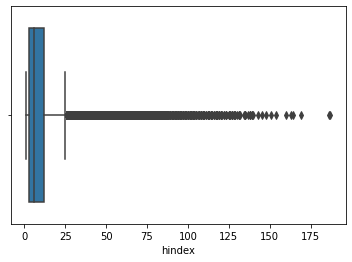

In [27]:
sns.boxplot(x = train["hindex"])

In [28]:
whole = pd.concat([train, test], axis = 0)
whole.reset_index(inplace=True)
whole_ = whole.copy()
whole_.set_index("author", inplace = True)

In [29]:
wholey = pd.concat([train["hindex"], test["hindex"]])
dico = {e : i for (i, e) in enumerate(wholey.index)}

In [30]:
print(whole.head(3))
print(whole_.head(3))

   index      author  hindex
0      0  1964267543     4.0
1      1  2153592714    13.0
2      2   217158525     8.0
            index  hindex
author                   
1964267543      0     4.0
2153592714      1    13.0
217158525       2     8.0


In [31]:
import math
def process_avg(x):
    liste = [e for e in G.neighbors(x)]
    liste = [whole_["hindex"][e] for e in liste if math.isnan(whole_["hindex"][e]) == False]
    if len(liste) != 0 :
        return sum(liste)/len(liste)
    else :
        return 1.0
def process_min(x):
    liste = [e for e in G.neighbors(x)]
    liste = [whole_["hindex"][e] for e in liste if math.isnan(whole_["hindex"][e]) == False]
    if len(liste) != 0 :
        return min(liste)
    else :
        return 0.0
def process_max(x):
    liste = [e for e in G.neighbors(x)]
    liste = [whole_["hindex"][e] for e in liste if math.isnan(whole_["hindex"][e]) == False]
    if len(liste) != 0 :
        return max(liste)
    else :
        return 1.0

In [32]:
whole["average"] = whole["author"].apply(lambda x : process_avg(x))

In [33]:
whole["core_number"] = whole["author"].apply(lambda x : core_number[x])

In [34]:
whole["page_rank"] = whole["author"].apply(lambda x : page_rank[x])

In [35]:
whole["degree"] = whole["author"].apply(lambda x : G.degree(x))

In [36]:
whole["onion"] = whole["author"].apply(lambda x : onion_layers[x])

In [39]:
whole["avg_degree"] = whole["author"].apply(lambda x : average_neighbor_degree[x])
whole["triangles"] = whole["author"].apply(lambda x : triangles[x])
whole["clustering"] = whole["author"].apply(lambda x : -clustering[x])

In [41]:
train.set_index("author", inplace = True)
test.set_index("author", inplace = True)

In [42]:
train["degree"] = [G.degree[e] for e in train.index]
test["degree"] = [G.degree[e] for e in test.index]

In [44]:
#/content/drive/MyDrive/Data_Challenge/
abstracts = pd.read_csv("abstracts_bar.csv", sep = "|", engine = "python")

In [45]:
abstracts.head()

,paper_ID,IndexLength,InvertedIndex
0,3603,122,"{'In': [0], 'this': [1], 'paper,': [2], 'we': ..."
1,7383,192,"{'The': [0], 'paper': [1], 'starts': [2], 'fro..."
2,14309,102,"{'This': [0], 'contribution': [1], 'describes'..."
3,15548,54,"{'Cleaneval': [0], 'is': [1], 'a': [2, 26], 's..."
4,15883,141,"{'Xax': [0, 24], 'is': [1], 'a': [2, 26, 50, 5..."


In [46]:
import functools
def compare(a, b):
    return a[1]-b[1] 
def processing(x):
    liste = []
    x = ast.literal_eval(x)
    for e in x.keys():
        for b in x[e]:
            liste.append((e, b))
    liste = sorted(liste, key = functools.cmp_to_key(compare))
    result = ' '.join([u for (u, v) in liste])
    return result.strip()

In [47]:
abstracts.head()

,paper_ID,IndexLength,InvertedIndex
0,3603,122,"{'In': [0], 'this': [1], 'paper,': [2], 'we': ..."
1,7383,192,"{'The': [0], 'paper': [1], 'starts': [2], 'fro..."
2,14309,102,"{'This': [0], 'contribution': [1], 'describes'..."
3,15548,54,"{'Cleaneval': [0], 'is': [1], 'a': [2, 26], 's..."
4,15883,141,"{'Xax': [0, 24], 'is': [1], 'a': [2, 26, 50, 5..."


In [48]:
abstracts.set_index("paper_ID", inplace = True)

In [49]:
def process_avg_2(x):
  x = [int(e) for e in x]
  liste = [abstracts["IndexLength"][e] for e in x if e in abstracts.index]
  if len(liste) != 0 :
    return sum(liste)/len(liste)
  else :
    return 0

author_papers["length"] = author_papers["paper_IDs"].apply(lambda x : process_avg_2(x))

In [50]:
whole["length"] = whole["author"].apply(lambda x : author_papers["length"][x])

In [51]:
whole["n_articles"] = whole["author"].apply(lambda x : len(author_papers["paper_IDs"][x]))

In [52]:
whole.corr()["hindex"].sort_values(ascending = False)

hindex         1.000000
onion          0.459289
degree         0.406326
page_rank      0.402164
average        0.363316
core_number    0.359067
avg_degree     0.358154
n_articles     0.323564
triangles      0.306164
length         0.161609
clustering     0.125795
author        -0.078556
index         -0.193269
Name: hindex, dtype: float64

In [53]:
whole.corr()

,index,author,hindex,average,core_number,page_rank,degree,onion,avg_degree,triangles,clustering,length,n_articles
index,1.000000,0.540115,-0.193269,-0.031153,0.011987,-0.123409,0.001317,-0.018180,0.020384,0.014964,-0.069108,-0.034582,-0.361759
author,0.540115,1.000000,-0.078556,0.014798,0.038076,-0.095820,0.029945,0.028352,0.048229,0.033530,-0.071389,0.006970,-0.191425
hindex,-0.193269,-0.078556,1.000000,0.363316,0.359067,0.402164,0.406326,0.459289,0.358154,0.306164,0.125795,0.161609,0.323564
average,-0.031153,0.014798,0.363316,1.000000,0.317096,-0.059472,0.318220,0.364180,0.419679,0.264027,-0.055210,0.150230,0.097017
core_number,0.011987,0.038076,0.359067,0.317096,1.000000,0.065822,0.969187,0.803496,0.928288,0.957866,-0.094301,0.002121,0.069620
page_rank,-0.123409,-0.095820,0.402164,-0.059472,0.065822,1.000000,0.159423,0.241557,0.018178,0.037816,0.297751,0.032373,0.221629
degree,0.001317,0.029945,0.406326,0.318220,0.969187,0.159423,1.000000,0.825227,0.911682,0.934035,-0.050273,0.025439,0.084680
onion,-0.018180,0.028352,0.459289,0.364180,0.803496,0.241557,0.825227,1.000000,0.827736,0.645918,-0.117017,0.124567,0.131439
avg_degree,0.020384,0.048229,0.358154,0.419679,0.928288,0.018178,0.911682,0.827736,1.000000,0.849862,-0.098950,0.050676,0.060592
triangles,0.014964,0.033530,0.306164,0.264027,0.957866,0.037816,0.934035,0.645918,0.849862,1.000000,-0.067860,-0.031800,0.049074


In [ ]:
abstracts["sentences"] = abstracts["InvertedIndex"].apply(lambda x : processing(x))

In [ ]:
from sklearn.impute import SimpleImputer
impute = SimpleImputer(missing_values = np.nan, strategy = 'mean')
scaler = StandardScaler()

## **Word Embeddings**

In [ ]:
import gensim
from gensim.models import Word2Vec, KeyedVectors, TfidfModel
from gensim.parsing.preprocessing import STOPWORDS
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
assert gensim.models.doc2vec.FAST_VERSION > -1, "This will be painfully slow otherwise"

In [ ]:
DIM_EMBEDDING = 300

In [ ]:
card_docs = [TaggedDocument(doc.split(' '), [i]) for i, doc in enumerate(abstracts["sentences"])]

In [ ]:
word2vec_model = Doc2Vec(vector_size = DIM_EMBEDDING, window = 2, min_count=1, workers = -1, epochs = 20)
word2vec_model.build_vocab(card_docs)
word2vec_model.train(card_docs, total_examples = model.corpus_count, epochs=model.epochs)

In [ ]:
P = abstracts["sentences"].apply(lambda x : word2vec_model.infer_vector(x.split(' ')))

In [ ]:
P = np.stack(P.values, axis = 0)

In [ ]:
P = pd.DataFrame(data = P, index = abstracts["paper_ID"], columns = np.arange(DIM_EMBEDDING))

In [ ]:
P.head(5)

In [ ]:
def process_embed(x):
    v = [int(e) for e in x if int(e) in P.index]
    if len(v) != 0 :
        return sum([P.loc[e, :].values for e in v])/len(v)
    else :
        k = np.zeros((DIM_EMBEDDING,))
        k[:] = np.NaN
        return k

In [ ]:
X_total = author_papers["paper_IDs"].apply(lambda x : process_embed(x))

In [ ]:
X_total = np.stack(X_total.to_numpy(), axis = 0)

In [ ]:
X_total = pd.DataFrame(data = X_total, index = author_papers.index, columns = np.arange(DIM_EMBEDDING))

In [ ]:
X_total.isna().sum()

In [ ]:
X_total = impute.fit_transform(X_total)
X_total = pd.DataFrame(data = X_total, index = author_papers.index,columns = np.arange(DIM_EMBEDDING))

In [ ]:
X_total.head()

In [ ]:
X = X_total.loc[train.index,:]
y = train["hindex"]
X_test = X_total.loc[test.index,:]

## **TF-IDF**

In [55]:
from sklearn.decomposition import TruncatedSVD, PCA, SparsePCA

In [56]:
DIMENSION = 500

In [57]:
def clean(x):
    return x.lower().replace("\n", " ")
#vect = TfidfVectorizer(preprocessor = clean, max_features = 5000)
vect = TfidfVectorizer(preprocessor = clean, max_features = DIMENSION)

In [ ]:
Q = vect.fit_transform(abstracts["sentences"]).todense()

In [ ]:
#Q = vect.fit_transform(abstracts["sentences"])
#Q = PCA(n_components = DIMENSION).fit_transform(Q)
#Q = TruncatedSVD(n_components = DIMENSION, random_state = 42).fit_transform(Q)

In [ ]:
Q = pd.DataFrame(data = Q, index = abstracts.index, columns = np.arange(DIMENSION))

In [ ]:
Q.head(3)

In [ ]:
def process_tfidf(x):
    v = [int(e) for e in x if int(e) in Q.index]
    if len(v) != 0 :
        return sum([Q.loc[e, :].values for e in v])/len(v)
    else :
        k = np.zeros((DIMENSION,))
        k[:] = np.NaN
        return k

In [ ]:
X_total_ = author_papers["paper_IDs"].apply(lambda x : process_tfidf(x))

In [ ]:
X_total_ = np.stack(X_total_.to_numpy(), axis = 0)

In [ ]:
X_total_ = pd.DataFrame(data = X_total_, index = author_papers.index, columns = np.arange(DIMENSION))

In [ ]:
X_total_.head(3)

In [ ]:
X_total_.isna().sum()

In [ ]:
X_total_ = impute.fit_transform(X_total_)
X_total_ = pd.DataFrame(data = X_total_, index = author_papers.index,columns = np.arange(DIMENSION))

In [ ]:
X = X_total_.loc[train.index,:]
y = train["hindex"]
X_test = X_total_.loc[test.index,:]

## **Addition with graph features**

In [ ]:
whole.corr()["hindex"].sort_values(ascending = False)

In [ ]:
colonnes = [e for e in whole.columns if e not in ["index", "author", "hindex", "core_number", "triangles"]]
#colonnes = ["average", "page_rank", "n_articles"]
X_ = whole.loc[:, colonnes].values
A = X_[0:train.shape[0],:]
X = np.concatenate([X, A], axis = 1)
A_test = X_[train.shape[0]:,:]
X_test = np.concatenate([X_test, A_test], axis = 1)

In [ ]:
colonnes

In [ ]:
X = scaler.fit_transform(X)
X_test = scaler.transform(X_test)

In [ ]:
X.shape

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = X_test.shape[0]/X.shape[0])

## **Feature selection**

In [ ]:
reg = LassoCV()
reg.fit(X_train, y_train)
print("Best alpha using built-in LassoCV : %f"%reg.alpha_)

Best alpha using built-in LassoCV : 0.347322


In [ ]:
coef = pd.Series(reg.coef_, index = list(np.arange(DIMENSION))+["average", "degree", "core_number"])

In [ ]:
print("Lasso picked "+str(sum(coef != 0))+" variables and eliminated the other "+str(sum(coef == 0))+" variables")

Lasso picked 3 variables and eliminated the other 1000 variables


Text(0.5, 1.0, 'Feature importance using Lasso Model')

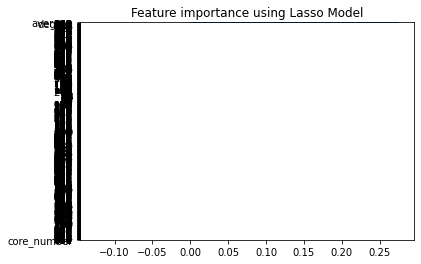

In [ ]:
imp_coef = coef.sort_values()
imp_coef.plot(kind = "barh")
plt.title("Feature importance using Lasso Model")

In [ ]:
def select_features(X, y, X_test):
  fs = SelectKBest(score_func = mutual_info_regression, k = 100)
  fs.fit(X, y)
  X_fs = fs.transform(X)
  X_test_fs = fs.transform(X_test)
  return X_fs, X_test_fs, fs

In [ ]:
X_fs, X_test_fs, _ = select_features(X, y, X_test)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_fs, y, test_size = 0.2)
X_test = X_test_fs

## **MODELS**

### **DNN**

In [ ]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
tf.debugging.set_log_device_placement(True)

Num GPUs Available:  1


In [ ]:
nnmodel = keras.Sequential()
nnmodel.add(keras.layers.Input(X.shape[1]))
nnmodel.add(keras.layers.Dense(64, activation='relu'))
nnmodel.add(keras.layers.Dropout(0.1))
nnmodel.add(keras.layers.Dense(1, activation='relu')) 

nnmodel.build((None, X.shape[1]))
print(nnmodel.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 64)                64576     
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                                 
Total params: 64,641
Trainable params: 64,641
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
nnmodel.compile(
    loss = 'mean_squared_error', 
    optimizer = keras.optimizers.Adam(0.01),
    metrics = ['mse']
)

In [ ]:
history = nnmodel.fit(
    X_train, y_train, 
    batch_size = 32, 
    epochs = 1000, 
    validation_data = (X_val, y_val),
    callbacks = keras.callbacks.EarlyStopping(patience = 10),
) 

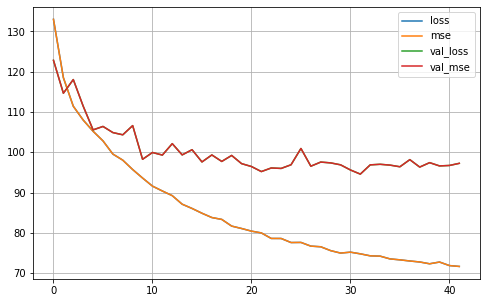

In [ ]:
pd.DataFrame(history.history).plot(figsize = (8, 5))
plt.grid(True)
plt.show()

In [ ]:
err = mean_squared_error(y_val, nnmodel.predict(X_val))
print('validation MSE with RNN:', err)

### **CATBOOST**

In [ ]:
model_cat = CatBoostRegressor(
    iterations = 500000,
    learning_rate = 0.05, 
    depth = 8,
    loss_function='RMSE', 
    verbose = 2,
    task_type = 'GPU',
)

In [ ]:
model_cat.fit(X_train, y_train,  eval_set = (X_val, y_val), early_stopping_rounds = 300)

In [ ]:
print(mean_squared_error(y_val, model_cat.predict(X_val)))

In [ ]:
feature_dict = {'Features': list(np.arange(DIMENSION)) + colonnes, 'Importance': model_cat.feature_importances_}
feature_imp = pd.DataFrame(feature_dict).sort_values(by = ['Importance'], ascending = False)
plt.figure(figsize=(10, 7))
df_imp = feature_imp.head(20)
sns.barplot(y = df_imp["Features"], x = df_imp["Importance"], palette = 'coolwarm_r')

### **XGBOOST**

In [ ]:
model_xg = XGBRegressor(**{
    'learning_rate': 0.05,
    'max_depth': 8,
    'subsample': 0.8,
    'n_estimators' : 70000,
    'objective': 'reg:squarederror',
    'tree_method':'gpu_hist',
    'n_jobs':-1
})

In [ ]:
eval_set = [(X_train, y_train), (X_val, y_val)]
eval_metric = ["rmse"]
%time model_xg.fit(X_train, y_train, eval_metric=eval_metric, eval_set=eval_set, verbose = True, early_stopping_rounds = 200)

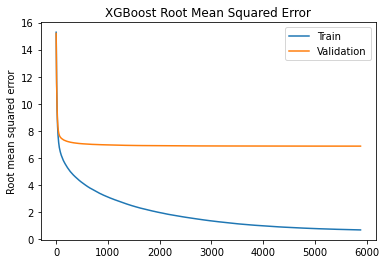

In [ ]:
results = model_xg.evals_result()
epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['rmse'], label='Train')
ax.plot(x_axis, results['validation_1']['rmse'], label='Validation')
ax.legend()
plt.ylabel('Root mean squared error')
plt.title('XGBoost Root Mean Squared Error')
plt.show()

In [ ]:
print(mean_squared_error(y_val, model_xg.predict(X_val)))

47.167254217926235


### **LIGHTGBM**

In [ ]:
model_lgbm = LGMRegressor(
    'learning_rate':0.05,
    'max_depth':8,
    'boosting_type':'gbdt',
    'n_estimators': 50000,
    'objective':'regression'
)

In [ ]:
model_lgbm.fit(X_train, y_train)

In [ ]:
print(mean_squared_error(y_val, model_lgbm.predict(X_val)))

### **VOTINGREGRESSOR**

In [ ]:
from sklearn.ensemble import VotingRegressor, GradientBoostingRegressor

In [ ]:
model_v = VotingRegressor([('cat', model_cat), ('xg', model_xg)], verbose = 2)

In [ ]:
model_v.fit(X_train, y_train)

In [ ]:
print(mean_squared_error(y_val, model_v.predict(X_val)))

46.31210108647375


## **SUBMIT**

In [ ]:
final_model = model_cat

In [ ]:
final_model.fit(np.concatenate([X_train, X_val], axis = 0), np.concatenate([y_train, y_val], axis = 0), verbose = 2)

In [88]:
prediction = final_model.predict(X_test)
print((prediction < 1).sum())
prediction[prediction <= 1] = 1

2423


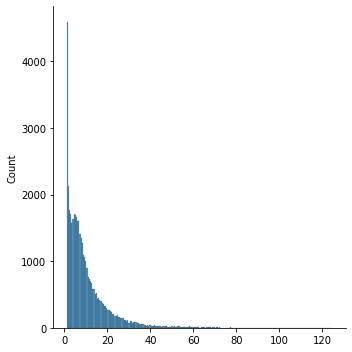

In [89]:
sns.displot(prediction)

In [90]:
#/content/drive/MyDrive/Data_Challenge/
submission = pd.read_csv("submission.csv")
submission["hindex"] = prediction

In [91]:
submission.to_csv("submit.csv", index = False)